# Bidirectional Quadratic Voting

## Simulation

The simulation settings are inspired by [Tokyo Governor Election (July 7, 2024) Voting Results](https://www.senkyo.metro.tokyo.lg.jp/election/tochiji-all/tochiji-sokuhou2024/). However, please note that these settings are insufficient to simulate an actual election and contain arbitrary assumptions. They should be considered for reference purposes only. 

### Preparation

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### Simulator

In [2]:
# Function to generate candidate preferences
def generate_candidate_preferences(num_candidates, num_issues, ideology_range):
    # Initialize array to store candidate preferences
    candidate_preferences = np.zeros((num_candidates, num_issues))
    
    # Generate preferences for each candidate
    for i, ideology in enumerate(ideology_range):
        # Issue 0: Environmental Protection (inversely related to ideology)
        candidate_preferences[i, 0] = np.clip(-ideology + np.random.normal(0, 0.1), -1, 1)
        
        # Issue 1: Economic Growth (directly related to ideology)
        candidate_preferences[i, 1] = np.clip(ideology + np.random.normal(0, 0.1), -1, 1)
        
        # Issue 2: Education Reform (weakly related to ideology)
        candidate_preferences[i, 2] = np.clip(ideology * 0.2 + np.random.normal(0, 0.2), -1, 1)
        
        # Issue 3: Social Security (strongly inversely related to ideology)
        candidate_preferences[i, 3] = np.clip(-ideology * 0.8 + np.random.normal(0, 0.1), -1, 1)
        
        # Issue 4: Foreign Policy (moderately related to ideology)
        candidate_preferences[i, 4] = np.clip(ideology * 0.5 + np.random.normal(0, 0.1), -1, 1)
        
        # Issue 5: Technology (high for candidate 2, low for others)
        candidate_preferences[i, 5] = 0.8 if i == 1 else np.clip(-0.4 + np.random.normal(0, 0.1), -1, 1)
        
        # Issue 6: Political Performance (fixed values for each candidate)
        candidate_preferences[i, 6] = [0.4, -0.8, 0.2, 0.8, -0.4][i]
        
        # Issue 7: SNS Utilization (high for candidate 3, low for others)
        candidate_preferences[i, 7] = 0.8 if i == 2 else np.clip(-0.4 + np.random.normal(0, 0.1), -1, 1)
    
    return candidate_preferences

# Function to generate voter preferences
def generate_voter_preferences(num_voters, num_issues, ideology_distribution):
    # Generate voter ideologies based on the specified distribution
    if ideology_distribution == 'normal':
        voter_ideologies = np.random.normal(0, 0.3, num_voters)
    elif ideology_distribution == 'bimodal':
        voter_ideologies = np.concatenate([np.random.normal(-0.5, 0.2, num_voters//2), np.random.normal(0.5, 0.2, num_voters//2)])
    elif ideology_distribution == 'skewed_left':
        voter_ideologies = np.random.beta(2, 5, num_voters) * 2 - 1
    elif ideology_distribution == 'skewed_right':
        voter_ideologies = np.random.beta(5, 2, num_voters) * 2 - 1
    else:
        raise ValueError("Invalid ideology distribution specified")

    # Generate voter preferences based on their ideologies
    voter_preferences = np.zeros((num_voters, num_issues))
    for i, ideology in enumerate(voter_ideologies):
      voter_preferences[i] = np.clip(ideology + np.random.normal(0, 0.2, num_issues), -1, 1)

    # Adjust preferences for technology (issue 5)
    tech_voters = np.random.choice(num_voters, int(num_voters * 0.05), replace=False)
    voter_preferences[tech_voters, 5] = np.random.uniform(0.6, 1.0, len(tech_voters))
    voter_preferences[~np.isin(np.arange(num_voters), tech_voters), 5] = np.random.uniform(-1.0, 0.0, num_voters - len(tech_voters))

    # Adjust preferences for political performance (issue 6)
    performance_voters = np.random.choice(num_voters, int(num_voters * 0.6), replace=False)
    voter_preferences[performance_voters, 6] = np.random.uniform(0.6, 1.0, len(performance_voters))
    voter_preferences[~np.isin(np.arange(num_voters), performance_voters), 6] = np.random.uniform(0.0, 0.6, num_voters - len(performance_voters))
    
    # Adjust preferences for SNS utilization (issue 7)
    sns_voters = np.random.choice(num_voters, int(num_voters * 0.1), replace=False)
    voter_preferences[sns_voters, 7] = np.random.uniform(0.6, 1.0, len(sns_voters))
    voter_preferences[~np.isin(np.arange(num_voters), sns_voters), 7] = np.random.uniform(-1.0, 0.6, num_voters - len(sns_voters))

    return voter_preferences, voter_ideologies

# Function to generate candidate platforms with some noise
def generate_candidate_platforms(candidate_preferences, noise_level=0.1):
    return candidate_preferences + np.random.normal(0, noise_level, candidate_preferences.shape)

# Function to generate voter perceptions of candidate platforms with noise
def generate_voter_perceptions(candidate_platforms, num_voters, noise_level=0.2):
    return np.array([candidate_platforms + np.random.normal(0, noise_level, candidate_platforms.shape) for _ in range(num_voters)])

# Function to implement quadratic voting
def quadratic_voting(preferences, credits):
    pref_range = np.max(preferences) - np.min(preferences)
    if pref_range == 0:
        # If all preferences are the same, vote equally
        return np.full_like(preferences, np.sqrt(credits / len(preferences)))

    normalized_prefs = (preferences - np.min(preferences)) / pref_range
    votes = np.sign(normalized_prefs) * np.sqrt(np.abs(normalized_prefs))
    total_cost = np.sum(votes**2)
    if total_cost > 0:
        scale_factor = np.sqrt(credits / total_cost)
        votes = votes * scale_factor
    return votes

# Function to calculate cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Function to calculate normal voting scores
def calculate_normal_voting_scores(voter_preferences, voter_perceptions):
    num_voters, num_candidates, _ = voter_perceptions.shape
    scores = np.zeros(num_candidates)

    for voter, perceptions in zip(voter_preferences, voter_perceptions):
        similarities = [cosine_similarity(voter, candidate) for candidate in perceptions]
        scores[np.argmax(similarities)] += 1

    return scores / np.sum(scores)

# Function to calculate quadratic voting scores
def calculate_qv_scores(voter_preferences, voter_perceptions):
    num_voters, num_candidates, _ = voter_perceptions.shape
    scores = np.zeros(num_candidates)

    for voter, perceptions in zip(voter_preferences, voter_perceptions):
        voter_votes = quadratic_voting(voter, 100)
        candidate_scores = [cosine_similarity(voter_votes, candidate) for candidate in perceptions]
        normalized_scores = (candidate_scores - np.min(candidate_scores)) / (np.max(candidate_scores) - np.min(candidate_scores))
        scores += normalized_scores

    return scores / np.sum(scores)

# Function to calculate bidirectional quadratic voting scores
def calculate_bqv_scores(voter_preferences, candidate_preferences):
    num_voters, num_issues = voter_preferences.shape
    num_candidates = candidate_preferences.shape[0]
    scores = np.zeros(num_candidates)

    for voter in voter_preferences:
        # Calculate BQV excluding political performance, technology, and SNS utilization
        voter_votes = quadratic_voting(np.concatenate([voter[:6], voter[7:]]), 100)
        candidate_votes = [quadratic_voting(np.concatenate([candidate[:6], candidate[7:]]), 100) for candidate in candidate_preferences]
        candidate_scores = [cosine_similarity(voter_votes, c_votes) for c_votes in candidate_votes]
        normalized_scores = (candidate_scores - np.min(candidate_scores)) / (np.max(candidate_scores) - np.min(candidate_scores))
        scores += normalized_scores

    return scores / np.sum(scores)

# Function to run the entire simulation
def run_simulation(num_voters, num_candidates, num_issues, ideology_distribution):
    candidate_preferences = generate_candidate_preferences(num_candidates, num_issues, np.linspace(-1, 1, num_candidates))
    voter_preferences, voter_ideologies = generate_voter_preferences(num_voters, num_issues, ideology_distribution)

    candidate_platforms = generate_candidate_platforms(candidate_preferences)
    voter_perceptions = generate_voter_perceptions(candidate_platforms, num_voters)

    normal_scores = calculate_normal_voting_scores(voter_preferences, voter_perceptions)
    qv_scores = calculate_qv_scores(voter_preferences, voter_perceptions)
    bqv_scores = calculate_bqv_scores(voter_preferences, candidate_preferences)

    return voter_ideologies, normal_scores, qv_scores, bqv_scores

### Prerequisites

In [3]:
# Define the list of political issues to be considered in the simulation
issues = ['Environmental Protection', 'Economic Growth', 'Education Reform', 'Social Security', 'Foreign Policy', 'Technology', 'Political Performance', 'SNS Utilization']

# Calculate the total number of issues
num_issues = len(issues)

# Set the number of candidates participating in the election
num_candidates = 5

# Create a list of candidate names (Candidate1, Candidate2, etc.)
candidates = [f'Candidate{i+1}' for i in range(num_candidates)]

# Set the number of voters participating in the simulation
num_voters = 10000

# Create an array of ideological positions ranging from -1 (far left) to 1 (far right)
# The number of points in this range equals the number of candidates
ideology_range = np.linspace(-1, 1, num_candidates)

# Define the different voter distribution types to be simulated
# These represent different scenarios of how voters might be distributed across the ideological spectrum
voter_distributions = ['normal', 'bimodal', 'skewed_left', 'skewed_right']

### Simulation

#### Candidate Preferences

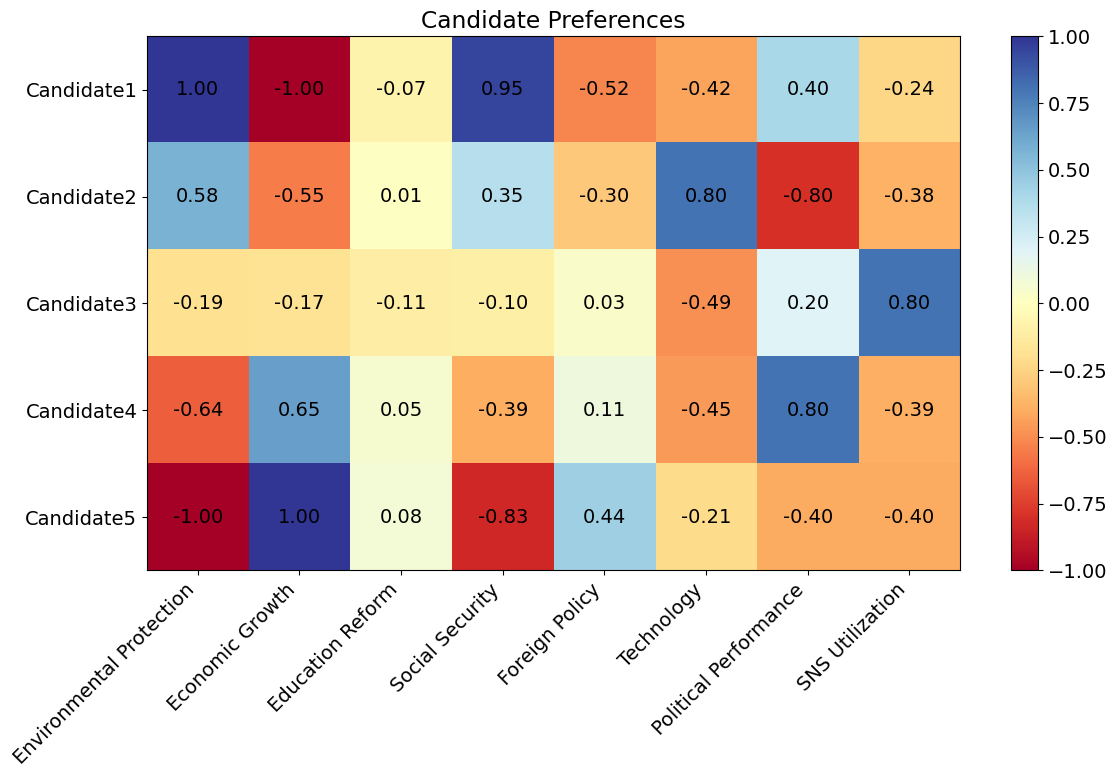

In [4]:
# Run the simulation and generate candidate preferences
results = {}
candidate_preferences = generate_candidate_preferences(5, 8, np.linspace(-1, 1, 5))

# Iterate through different voter distributions and run simulations
for v_dist in ['normal', 'bimodal', 'skewed_left', 'skewed_right']:
    # Run simulation for each distribution and store results
    voter_ideologies, normal_scores, qv_scores, bqv_scores = run_simulation(10000, 5, 8, v_dist)
    results[v_dist] = (voter_ideologies, normal_scores, qv_scores, bqv_scores)

# Set up visualization parameters
plt.rcParams.update({'font.size': 14})
candidates = [f'Candidate{i+1}' for i in range(5)]

# Create a heatmap to visualize candidate preferences
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(candidate_preferences, cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)

# Set up x and y axis labels
ax.set_xticks(np.arange(len(issues)))
ax.set_yticks(np.arange(len(candidates)))
ax.set_xticklabels(issues, rotation=45, ha='right')
ax.set_yticklabels(candidates)

# Add a colorbar to the heatmap
plt.colorbar(im)

# Set the title of the heatmap
ax.set_title('Candidate Preferences')

# Add text labels to each cell in the heatmap
for i in range(len(candidates)):
    for j in range(len(issues)):
        text = ax.text(j, i, f'{candidate_preferences[i, j]:.2f}',
                       ha="center", va="center", color="black")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Voters Distribution

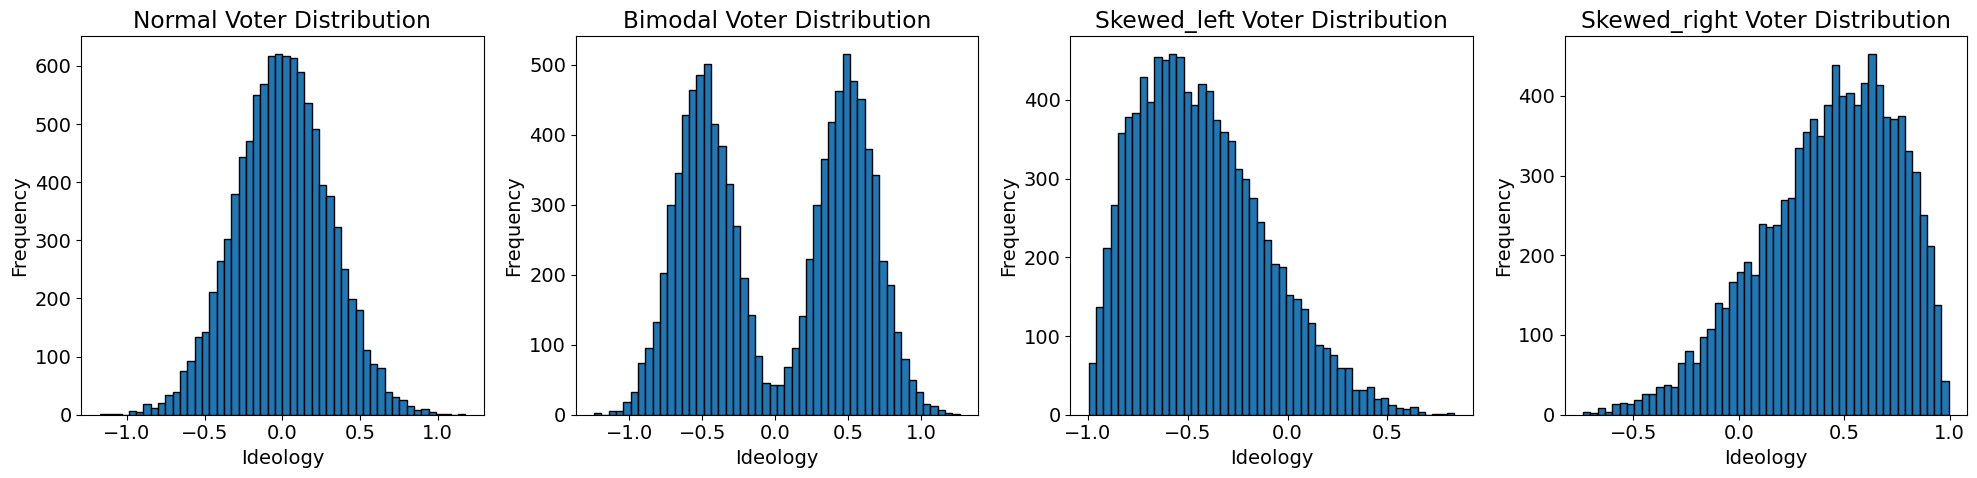

In [5]:
# Visualize voter distributions for different scenarios
# Create a figure with 4 subplots, one for each distribution type
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Iterate through the results dictionary
for i, (v_dist, (voter_ideologies, _, _, _)) in enumerate(results.items()):
    # Create a histogram for each voter distribution
    axes[i].hist(voter_ideologies, bins=50, edgecolor='black')
    
    # Set the title for each subplot, capitalizing the distribution name
    axes[i].set_title(f'{v_dist.capitalize()} Voter Distribution')
    
    # Label the x-axis as "Ideology"
    axes[i].set_xlabel('Ideology')
    
    # Label the y-axis as "Frequency"
    axes[i].set_ylabel('Frequency')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

#### Voting Results

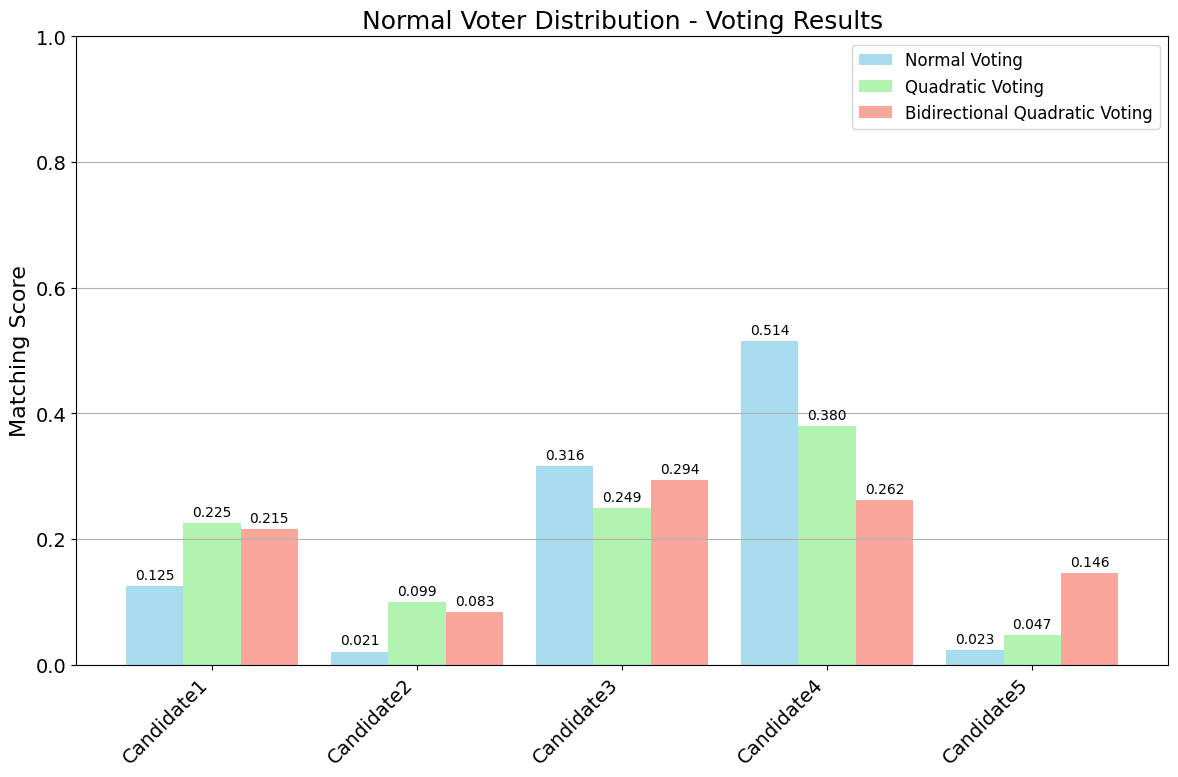

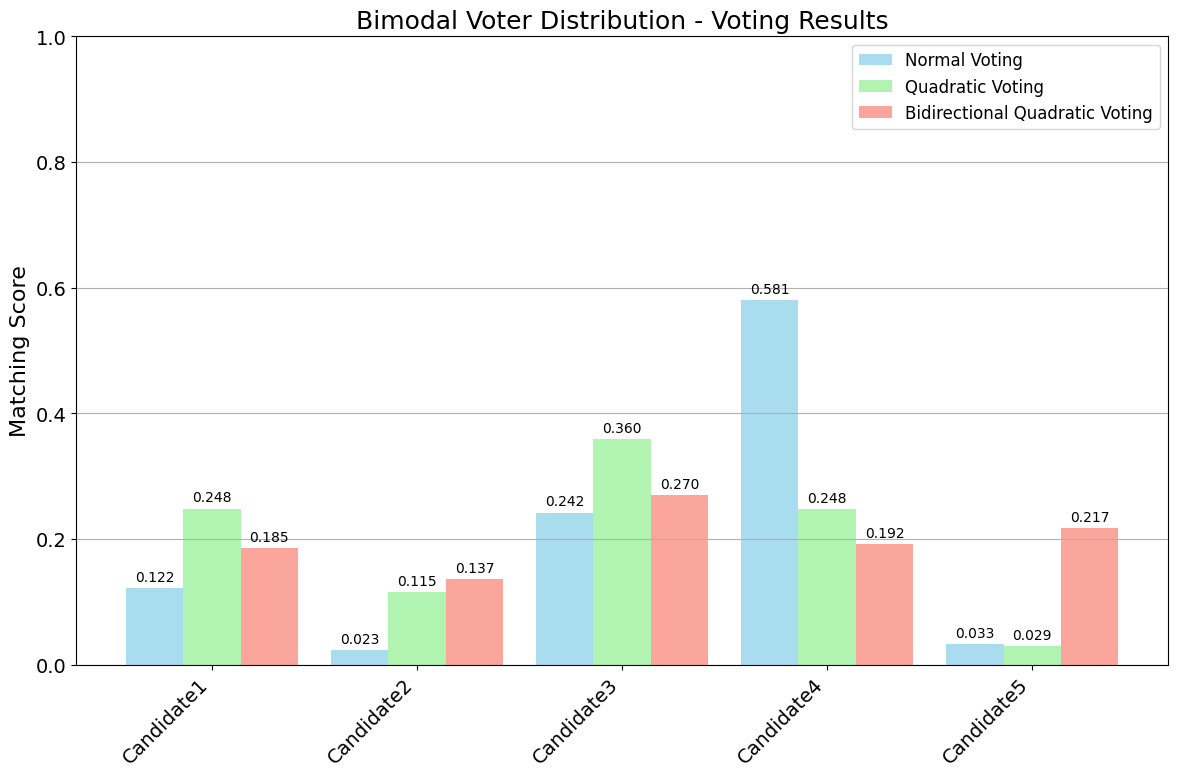

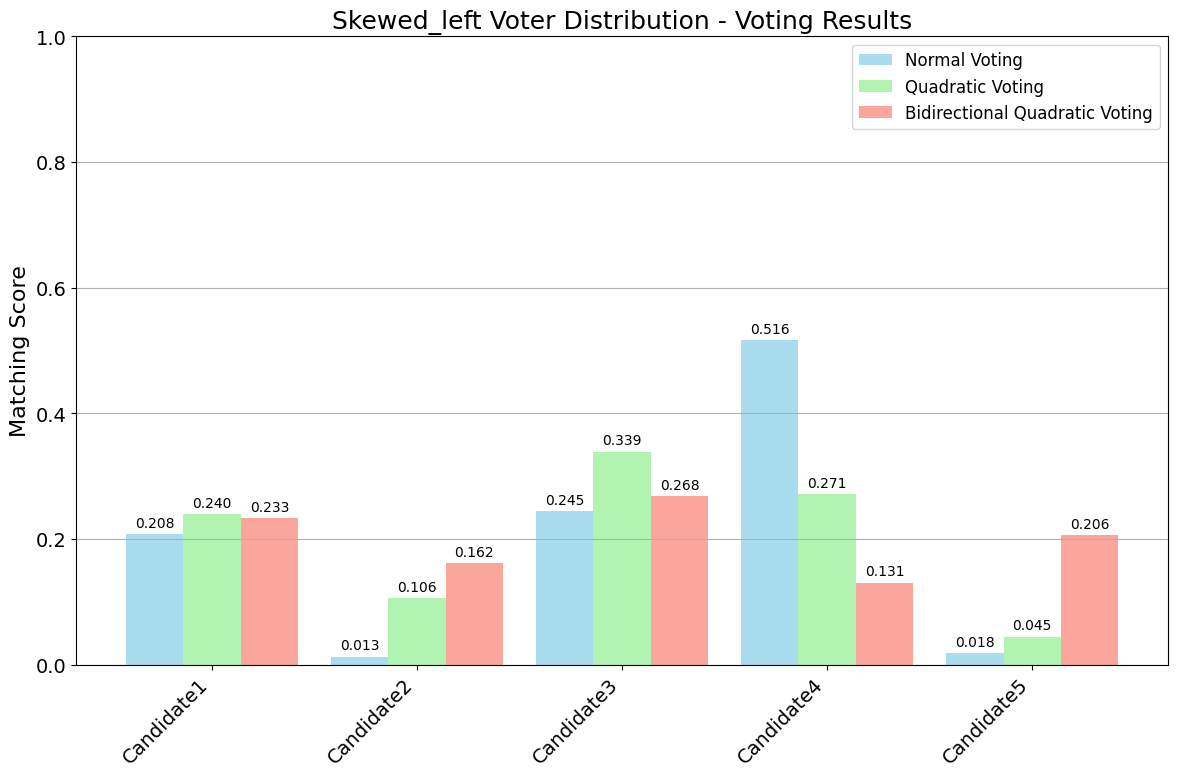

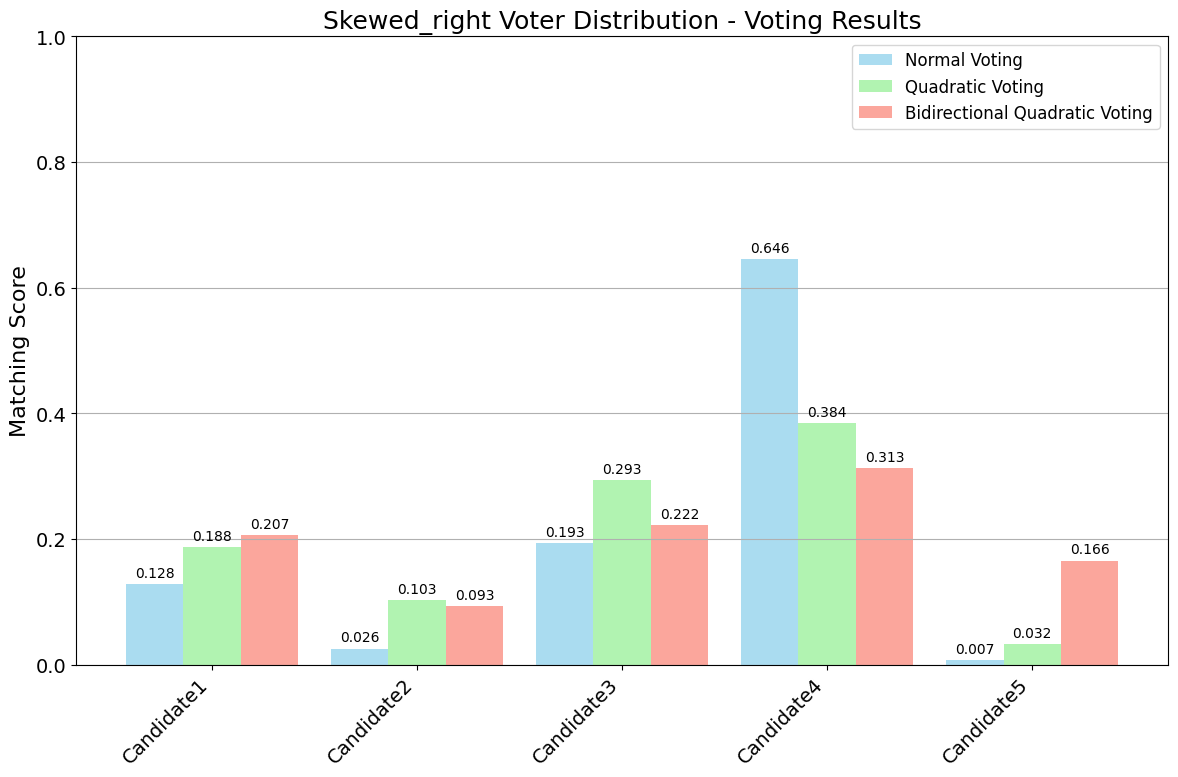

In [6]:
# Visualize voting results
# Update the global font size for better readability
plt.rcParams.update({'font.size': 14})

# Iterate through each voter distribution scenario in the results
for v_dist, (_, normal_scores, quadratic_scores, bidirectional_scores) in results.items():
    # Create a new figure and axis for each distribution
    fig, ax_match = plt.subplots(figsize=(12, 8))
    
    # Set up the x-axis for the bar chart
    x = np.arange(len(candidates))
    width = 0.28  # Width of each bar

    # Create bar plots for each voting method
    rects1 = ax_match.bar(x - width, normal_scores, width, label='Normal Voting', color='skyblue', alpha=0.7)
    rects2 = ax_match.bar(x, quadratic_scores, width, label='Quadratic Voting', color='lightgreen', alpha=0.7)
    rects3 = ax_match.bar(x + width, bidirectional_scores, width, label='Bidirectional Quadratic Voting', color='salmon', alpha=0.7)

    # Set labels, title, and other chart properties
    ax_match.set_ylabel('Matching Score', fontsize=16)
    ax_match.set_title(f'{v_dist.capitalize()} Voter Distribution - Voting Results', fontsize=18)
    ax_match.set_xticks(x)
    ax_match.set_xticklabels(candidates, rotation=45, ha='right', fontsize=14)
    ax_match.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
    ax_match.legend(fontsize=12)
    ax_match.grid(axis='y')  # Add horizontal grid lines

    # Define a function to add labels on top of each bar
    def autolabel(rects, scores):
        for rect, score in zip(rects, scores):
            height = rect.get_height()
            ax_match.annotate(f'{score:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    # Apply the autolabel function to each set of bars
    autolabel(rects1, normal_scores)
    autolabel(rects2, quadratic_scores)
    autolabel(rects3, bidirectional_scores)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()